In [1]:
import numpy as np
import pickle
from sklearn.linear_model import LogisticRegression
from skopt import BayesSearchCV
import pandas as pd
# from sklearn.metrics import precision_recall_curve, auc, roc_curve, confusion_matrix, f1_score, roc_auc_score
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    f1_score,
    precision_score,
    recall_score,
    precision_recall_curve,
    auc,
    confusion_matrix,
    accuracy_score
)
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
import seaborn as sns

In [2]:
# X_data = pd.read_csv('/home/bram/bramenv/matrices/finalmatrix.csv')
# y_data_pre = pd.read_csv('/home/bram/bramenv/matrices/full_annotations_ordered2.csv')

matrix = pd.read_csv('/home/bram/bramenv/aa_test_2 matrix/newmatrix_final.csv')

# Drop the 'annot' column to create X_data
X_data = matrix.drop('annot', axis=1)

# Extract the 'BDSPPatientID' and 'annot' columns to create y_data_pre
y_data_pre = matrix[['BDSPPatientID', 'annot']]

print(X_data)
print(y_data_pre)
assert len(X_data) == len(y_data_pre), "DataFrames must have the same length"
X_data['annot']=y_data_pre['annot']
print(X_data)

X_data=X_data.sample(frac=1, random_state=2023)
y_data = X_data[['BDSPPatientID', 'annot', 'hospital']]
print(y_data)
y_data_pre=y_data
print(y_data_pre)
y = y_data_pre['annot']
print(y)

X_data=X_data.drop(['annot'], axis=1)
X=X_data.drop(['BDSPPatientID', 'CreateDate', 'hospital'], axis=1) #dopamine and dopamineagonist?
print(X)


      BDSPPatientID  CreateDate hospital  parkinson disease_pos  pd_pos  \
0         150709433  2017-10-23    BIDMC                      0       0   
1         150669096  2022-03-09    BIDMC                      0       0   
2         151275717  2018-05-01    BIDMC                      0       0   
3         151013494  2021-06-09    BIDMC                      0       0   
4         150642824  2021-11-24    BIDMC                      0       0   
...             ...         ...      ...                    ...     ...   
3822      119272633  2022-07-07      MGB                      1       0   
3823      113316634  2021-11-08      MGB                      0       0   
3824      116513628  2021-10-03      MGB                      1       0   
3825      119530902  2022-06-04      MGB                      0       1   
3826      120000076  2022-03-21      MGB                      0       1   

      parkinson_pos  parkinsonismx_pos  disease_pos  akathisia_pos  \
0                 0          

In [3]:
matrix['ICD'].sum()

1282

In [4]:
X_data['hospital'].unique()

array(['MGB', 'STF', 'BIDMC'], dtype=object)

In [5]:
train_hospitals = ['BIDMC', 'STF']
test_hospital = 'MGB'

In [6]:
print(y_data)

      BDSPPatientID  annot hospital
2676      115418423      0      MGB
2611      115999654      0      MGB
1720      177513327      0      STF
2075      119646649      1      MGB
924       151270446      1    BIDMC
...             ...    ...      ...
1953      121265628      0      MGB
2743      112501365      0      MGB
2502      115578163      0      MGB
1561      177546956      0      STF
855       150629862      1    BIDMC

[3827 rows x 3 columns]


In [7]:
y_data['hospital'].isin(train_hospitals)

2676    False
2611    False
1720     True
2075    False
924      True
        ...  
1953    False
2743    False
2502    False
1561     True
855      True
Name: hospital, Length: 3827, dtype: bool

In [8]:
X_train = X[y_data['hospital'].isin(train_hospitals)]
y_train = y[y_data['hospital'].isin(train_hospitals)]
X_test = X[y_data['hospital'] == test_hospital]
y_test = y[y_data['hospital'] == test_hospital]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1863, 255) (1863,)
(1964, 255) (1964,)


In [9]:
print(X)

      parkinson disease_pos  pd_pos  parkinson_pos  parkinsonismx_pos  \
2676                      0       0              0                  0   
2611                      0       0              0                  0   
1720                      0       0              0                  0   
2075                      0       0              1                  1   
924                       1       0              1                  0   
...                     ...     ...            ...                ...   
1953                      0       0              0                  0   
2743                      0       0              0                  0   
2502                      0       0              0                  0   
1561                      0       0              0                  0   
855                       1       0              1                  0   

      disease_pos  akathisia_pos  anosmia_pos  apraxia_pos  autonomic_pos  \
2676            0              0            0 

In [10]:
print(y_test)

2676    0
2611    0
2075    1
2634    0
2413    0
       ..
2838    1
2563    0
1953    0
2743    0
2502    0
Name: annot, Length: 1964, dtype: int64


In [11]:

false_positives = []
false_negatives = []
patient_ids = y_data_pre['BDSPPatientID'][y_data['hospital'] == test_hospital]
print(patient_ids)
patient_ids=patient_ids.reset_index(drop=True)
print(patient_ids)

2676    115418423
2611    115999654
2075    119646649
2634    119199989
2413    114895585
          ...    
2838    111841075
2563    117084990
1953    121265628
2743    112501365
2502    115578163
Name: BDSPPatientID, Length: 1964, dtype: int64
0       115418423
1       115999654
2       119646649
3       119199989
4       114895585
          ...    
1959    111841075
1960    117084990
1961    121265628
1962    112501365
1963    115578163
Name: BDSPPatientID, Length: 1964, dtype: int64


In [12]:

all_predictions_nonbin=[]
all_predictions = []
all_true_labels = []
all_row_numbers = []

# outer loop
auc_cv = []
auc_pr = []
f1_cv = []
precision_sc=[]
recall_sc=[]
accuracy_sc=[]
cf_cv = []
final_Cs = []
final_l1 = []
predictions = []
roc_curves = []
pr_curves = []

# Dictionary to store feature importances
feature_importances_dict = {feature: [] for feature in X.columns}



model = LogisticRegression(
        penalty='elasticnet',
        class_weight=None, random_state=2023,
        solver='saga', max_iter=10000)

search_spaces = {
        'C': (1e-4, 1e+4, 'log-uniform'),  # adjusted this from 2 to 4
        'l1_ratio': (0.01, 0.99),
}
model_cv = BayesSearchCV(model,
        search_spaces,
        n_iter=50, scoring='roc_auc', n_jobs=15,
        cv=10, random_state=2023)
model_cv.fit(X_train, y_train)

#Find the Best hyperparameters and append them
best_hparams = model_cv.best_params_
best_C = best_hparams['C']
best_l1_ratio = best_hparams['l1_ratio']
final_Cs.append(best_C)
final_l1.append(best_l1_ratio)

model = model_cv.best_estimator_

# model_filename = 'model_train_MGB_BIDMC_test_Stanford_Notes+ICD+Med_best_model.pickle'
# with open(model_filename, 'wb') as f:
#     pickle.dump(model, f)

ytr_pred = model.predict_proba(X_train)[:,1]      # Xtr is training features, ytr is training labels, ytr_pred is training predictions = Prob(y=1|Xtr)
yte_pred = model.predict_proba(X_test)[:,1]    # Xte is testing features

fpr, tpr, cutoffs = roc_curve(y_train, ytr_pred) # changed this one to training
best_cutoff = cutoffs[np.argmax(tpr - fpr)]  # get best cut off from training set
yte_pred_bin =(yte_pred>best_cutoff).astype(int)
predictions.append(yte_pred_bin)

model_filename = 'model_train_MGB_BIDMC_test_Stanford_Notes+ICD+Med_best_model.pickle'
with open(model_filename, 'wb') as f:
    pickle.dump({'model':model, 'cutoff':best_cutoff}, f)

fpr, tpr, cutoffs = roc_curve(y_test, yte_pred) # repeat to get the fpr and tpr from testing set

auc_cv=roc_auc_score(y_test, yte_pred)
f1_cv=f1_score(y_test, yte_pred_bin)
cf_cv=confusion_matrix(y_test, yte_pred_bin)
precision_sc=precision_score(y_test, yte_pred_bin)
recall_sc=recall_score(y_test, yte_pred_bin)
accuracy_sc = accuracy_score(y_test, yte_pred_bin)

# Store the predictions and true labels for this fold
all_predictions_nonbin.extend(yte_pred)
all_predictions.extend(yte_pred_bin)
all_true_labels.extend(y_test)
all_row_numbers.extend(y_data[y_data['hospital'] == test_hospital]['BDSPPatientID'])

precision, recall, thresholds = precision_recall_curve(y_test, yte_pred)
auc_pr = auc(recall, precision)

# Save info for the plots
roc_curves.append((fpr, tpr, roc_auc_score(y_test, yte_pred)))
pr_curves.append((recall, precision, auc_pr))
# auc_pr_loop = auc(recall, precision)
# auc_pr.append(auc_pr_loop)




# Extract feature importances (coefficients)
feature_importances = model.coef_[0]
for feature, importance in zip(X.columns, feature_importances):
    feature_importances_dict[feature].append(importance)

print("Feature importances:")
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)
print(feature_importance_df)

print(auc_cv)
print(auc_pr)

all_true_labels = pd.Series(all_true_labels)
all_predictions = pd.Series(all_predictions)

false_positive_ids = patient_ids[(all_true_labels == 0) & (all_predictions == 1)]
false_negative_ids = patient_ids[(all_true_labels == 1) & (all_predictions == 0)]
false_positives.append(false_positive_ids)
false_negatives.append(false_negative_ids)
# Save false positives and false negatives to CSV files
false_positives_df = pd.DataFrame({'Fold': np.repeat(range(1), [len(fp) for fp in false_positives]), 'BDSPPatientID': np.concatenate(false_positives)})
false_negatives_df = pd.DataFrame({'Fold': np.repeat(range(1), [len(fn) for fn in false_negatives]), 'BDSPPatientID': np.concatenate(false_negatives)})

false_positives_df.to_csv('false_positives.csv', index=False)
false_negatives_df.to_csv('false_negatives.csv', index=False)

Feature importances:
                   Feature  Importance
2            parkinson_pos    4.139060
1                   pd_pos    2.207416
0    parkinson disease_pos    2.150867
208                    ICD    2.034549
99                 dbs_pos    1.897171
..                     ...         ...
20            dystonia_pos   -0.530286
58             saccade_pos   -0.575129
52             posture_pos   -0.753061
156            posture_neg   -1.070478
3        parkinsonismx_pos   -1.559229

[255 rows x 2 columns]
0.9662499114349715
0.9168908515625254


In [13]:
print(pr_curves)

[(array([1.        , 1.        , 1.        , ..., 0.00398406, 0.00199203,
       0.        ]), array([0.25560081, 0.25573102, 0.25586137, ..., 1.        , 1.        ,
       1.        ]), 0.9168908515625254)]


In [14]:
print(all_predictions)
print(all_true_labels)
print(patient_ids)

0       0
1       0
2       1
3       0
4       0
       ..
1959    0
1960    0
1961    0
1962    0
1963    0
Length: 1964, dtype: int64
0       0
1       0
2       1
3       0
4       0
       ..
1959    1
1960    0
1961    0
1962    0
1963    0
Length: 1964, dtype: int64
0       115418423
1       115999654
2       119646649
3       119199989
4       114895585
          ...    
1959    111841075
1960    117084990
1961    121265628
1962    112501365
1963    115578163
Name: BDSPPatientID, Length: 1964, dtype: int64


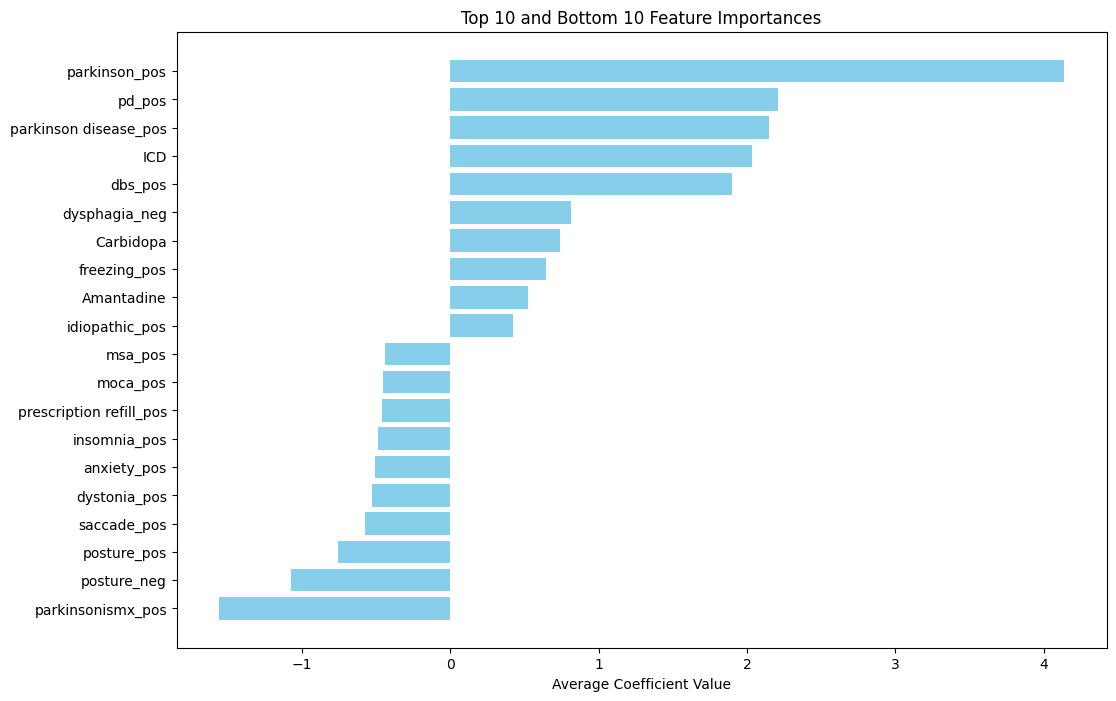

<Figure size 640x480 with 0 Axes>

In [15]:
# Save the DataFrame to a CSV file
feature_importance_df.to_csv(f'feat_importances.csv', index=False)

# Aggregate feature importances by averaging over folds
avg_feature_importances = {feature: np.mean(importances) for feature, importances in feature_importances_dict.items()}
sorted_features = sorted(avg_feature_importances.items(), key=lambda item: item[1], reverse=True)
features, importances = zip(*sorted_features)

# Select top 10 and bottom 10 features
top_features = features[:10]
top_importances = importances[:10]
bottom_features = features[-10:]
bottom_importances = importances[-10:]

# Combine top and bottom features for plotting
plot_features = top_features + bottom_features
plot_importances = top_importances + bottom_importances

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(plot_features, plot_importances, color='skyblue')
plt.xlabel('Average Coefficient Value')
plt.title('Top 10 and Bottom 10 Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

plt.savefig(f'feat_importances.png')

In [16]:
print(plot_features)

('parkinson_pos', 'pd_pos', 'parkinson disease_pos', 'ICD', 'dbs_pos', 'dysphagia_neg', 'Carbidopa', 'freezing_pos', 'Amantadine', 'idiopathic_pos', 'msa_pos', 'moca_pos', 'prescription refill_pos', 'insomnia_pos', 'anxiety_pos', 'dystonia_pos', 'saccade_pos', 'posture_pos', 'posture_neg', 'parkinsonismx_pos')


20


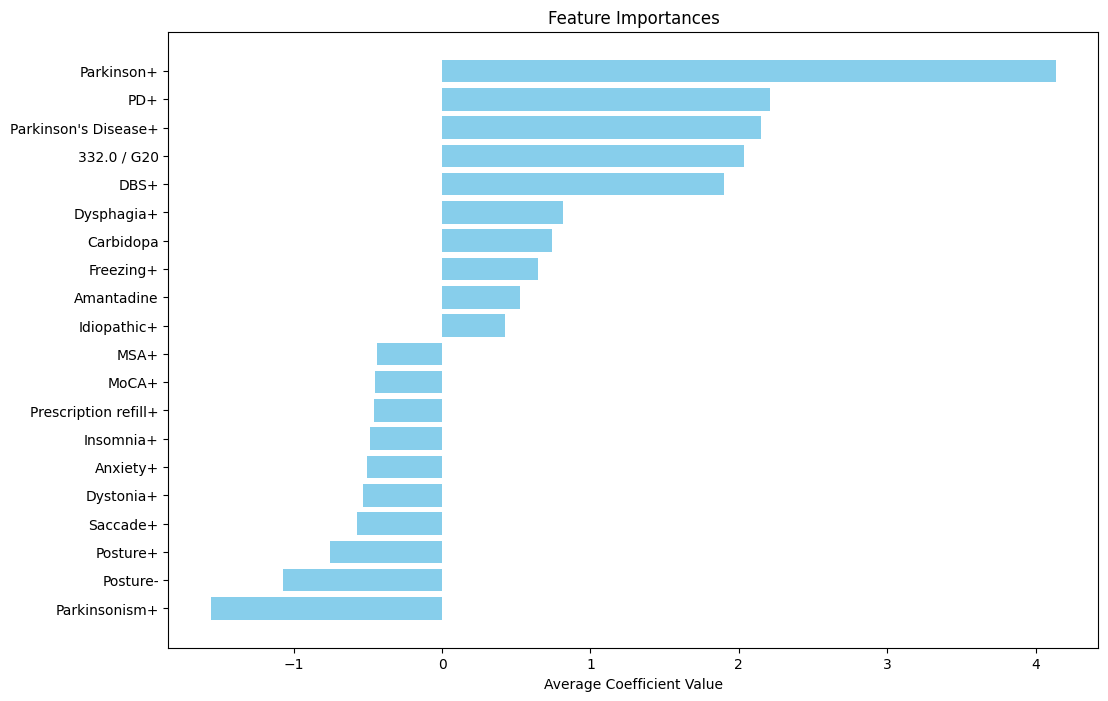

In [25]:
# Define custom feature names
custom_plot_features = [
    "Parkinson+","PD+", "Parkinson's Disease+", "332.0 / G20", 
   "DBS+","Dysphagia+", "Carbidopa", 
     'Freezing+', "Amantadine", 
   "Idiopathic+", "MSA+", 
     "MoCA+","Prescription refill+", "Insomnia+", "Anxiety+", 
    "Dystonia+","Saccade+", 'Posture+',"Posture-", "Parkinsonism+"
]
print(len(custom_plot_features))
# Ensure the length of custom features matches the length of plot_features
assert len(custom_plot_features) == len(plot_features), "The number of custom features must match the number of plot features."

# Plot feature importances
plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(plot_features)), plot_importances, color='skyblue')
plt.xlabel('Average Coefficient Value')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top

# Set custom y-axis labels
plt.yticks(range(len(plot_features)), custom_plot_features)

# Display the plot
plt.show()


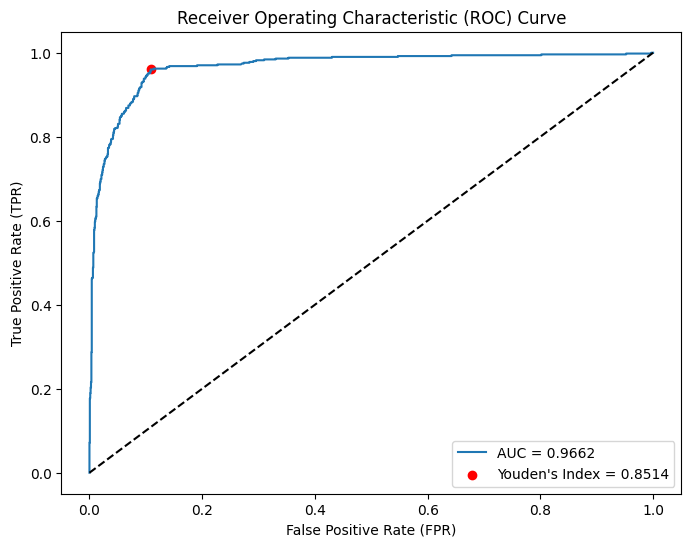

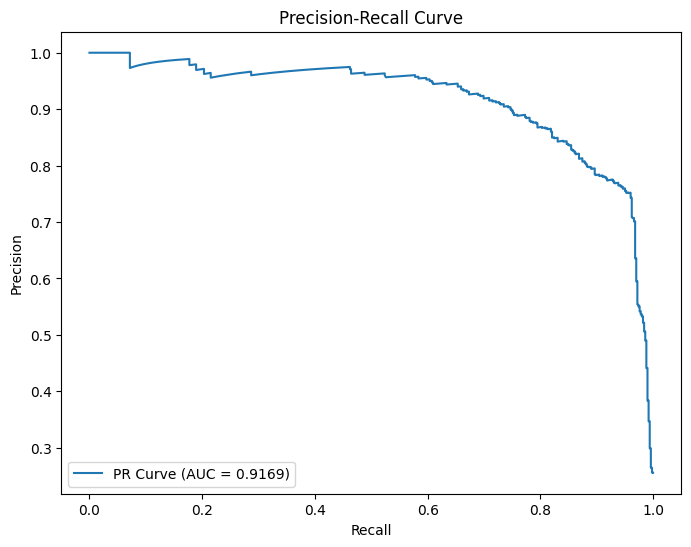

0.9662499114349715
0.9168908515625254
0.8449682683590208


In [18]:
# Plot all ROC curves overlayed on a single graph
plt.figure(figsize=(8, 6))

# plt.plot(fpr, tpr, label='AUC = {:.4f}'.format(auc_score))
# youden = np.max(tpr-fpr)
# plt.scatter(fpr[np.argmax(tpr-fpr)], tpr[np.argmax(tpr-fpr)], c='red', label=f'Youden\'s Index = {youden:.4f}')
for fpr, tpr, auc_score in roc_curves:
    plt.plot(fpr, tpr, label='AUC = {:.4f}'.format(auc_score))
    youden = np.max(tpr-fpr)
    plt.scatter(fpr[np.argmax(tpr-fpr)], tpr[np.argmax(tpr-fpr)], c='red', label=f'Youden\'s Index = {youden:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random classifier
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig(f'AUC_iter.png')
plt.show()

# Plot all PR curves overlayed on a single graph
plt.figure(figsize=(8, 6))
# plt.plot(recall, precision, label='PR Curve (AUC = {:.4f})'.format(auc_pr_loop))
# for recall, precision, auc_pr_loop in pr_curves:
#     plt.plot(recall, precision, label='PR Curve (AUC = {:.4f})'.format(auc_pr_loop))
for recall, precision, auc_pr_loop in pr_curves:
    if isinstance(auc_pr_loop, list):
        if len(auc_pr_loop) > 0:
            auc_pr_loop = float(auc_pr_loop[0])  # Adjust as necessary to extract the float
        else:
            raise ValueError("auc_pr_loop list is empty.")
    elif not isinstance(auc_pr_loop, float):
        raise TypeError("auc_pr_loop must be a float or convertible to a float.")
    plt.plot(recall, precision, label='PR Curve (AUC = {:.4f})'.format(auc_pr_loop))


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.savefig(f'PR_iter.png')
plt.show()


# Create a DataFrame to hold the results
results_df = pd.DataFrame({'Unnamed: 0': all_row_numbers, 'annot': all_true_labels, 'prediction BINARY': all_predictions, 'prediction': all_predictions_nonbin})

# Save the DataFrame to a CSV file
results_df.to_csv(f'LR_iter_pred.csv', index=False)

# Calculate the final AUC and F1
auc_final = np.mean(auc_cv)
f1_final = np.mean(f1_cv)

# Save all the data
df = pd.DataFrame()
df['auc'] = auc_cv
df['f1s'] = f1_cv
df['auc_pr'] = auc_pr
df['C'] = final_Cs
df['l1_ratio'] = final_l1
df_pred = pd.DataFrame()
df1 = pd.DataFrame(predictions[0])
df_pred = pd.concat([df1]).reset_index()
df.to_csv(f'LR_iter.csv')

# Print final Data
print(auc_final)
print(auc_pr)
print(f1_final)

In [19]:
# Sum all confusion matrices to get overall counts
overall_cf_matrix = np.sum(cf_cv, axis=0)
print("Overall Confusion Matrix:\n", overall_cf_matrix)

Overall Confusion Matrix:
 [1363  601]


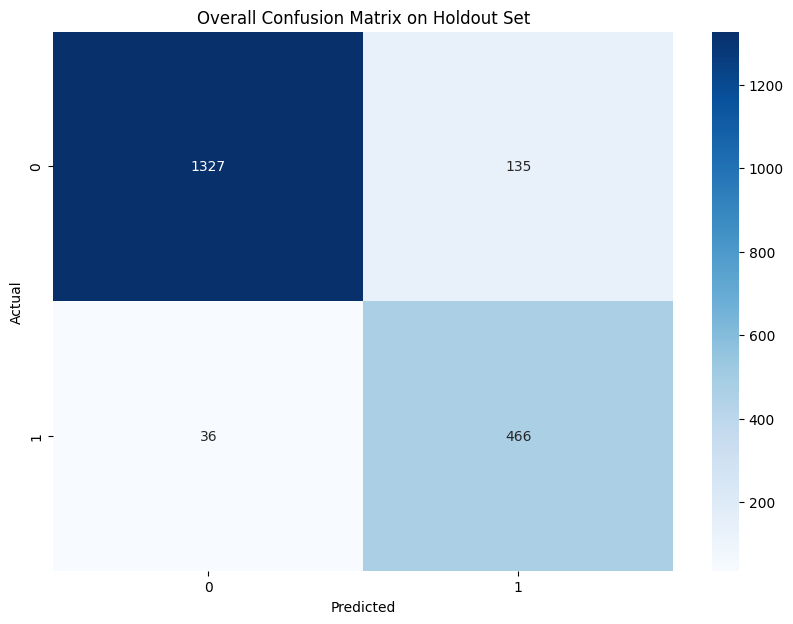

In [20]:
plt.figure(figsize=(10, 7))
sns.heatmap(cf_cv, annot=True, fmt='d', cmap='Blues')
plt.title('Overall Confusion Matrix on Holdout Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('overall_confusion_matrix_holdout.png')
plt.show()

In [21]:
# def calculate_metrics(cf_matrix):
#     TN, FP, FN, TP = cf_matrix.ravel()
#     accuracy = (TP + TN) / (TP + TN + FP + FN)
#     precision = TP / (TP + FP) if (TP + FP) > 0 else 0
#     recall = TP / (TP + FN) if (TP + FN) > 0 else 0
#     f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
#     return accuracy, precision, recall, f1

# # Calculate metrics for each fold
# for fold_index, cf_matrix in enumerate(cf_cv):
#     accuracy, precision, recall, f1 = calculate_metrics(cf_matrix)
#     print(f"Metrics for Fold {fold_index + 1}:")
#     print(f"Accuracy: {accuracy:.4f}")
#     print(f"Precision: {precision:.4f}")
#     print(f"Recall: {recall:.4f}")
#     print(f"F1 Score: {f1:.4f}\n")

# # Calculate overall metrics
# overall_cf_matrix = np.sum(cf_cv, axis=0)
# overall_accuracy, overall_precision, overall_recall, overall_f1 = calculate_metrics(overall_cf_matrix)
# print("Overall Metrics:")
# print(f"Accuracy: {overall_accuracy:.4f}")
# print(f"Precision: {overall_precision:.4f}")
# print(f"Recall: {overall_recall:.4f}")
# print(f"F1 Score: {overall_f1:.4f}")
def calculate_metrics(cf_matrix):
    TN, FP, FN, TP = cf_matrix.ravel()
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return accuracy, precision, recall, f1

overall_accuracy_holdout, overall_precision_holdout, overall_recall_holdout, overall_f1_holdout = calculate_metrics(cf_cv)
print("Overall Metrics on Holdout Set:")
print(f"Accuracy: {overall_accuracy_holdout:.4f}")
print(f"Precision: {overall_precision_holdout:.4f}")
print(f"Recall: {overall_recall_holdout:.4f}")
print(f"F1 Score: {overall_f1_holdout:.4f}")

Overall Metrics on Holdout Set:
Accuracy: 0.9129
Precision: 0.7754
Recall: 0.9283
F1 Score: 0.8450


In [22]:
# y_test=y_test.drop('index', axis=1)
y_test=y_test.reset_index(drop=True)

print(y_test)
print(yte_pred)
print(yte_pred_bin)
yte_pred_array=np.array(yte_pred)
yte_pred_bin_array=np.array(yte_pred_bin)
print(yte_pred_array)
print(yte_pred_bin_array)


0       0
1       0
2       1
3       0
4       0
       ..
1959    1
1960    0
1961    0
1962    0
1963    0
Name: annot, Length: 1964, dtype: int64
[0.00629715 0.0024179  0.61145752 ... 0.00480577 0.0085347  0.00877099]
[0 0 1 ... 0 0 0]
[0.00629715 0.0024179  0.61145752 ... 0.00480577 0.0085347  0.00877099]
[0 0 1 ... 0 0 0]


In [23]:
def bootstrap_resample(y_true, y_pred_proba, y_pred_bin, n_iterations=800, alpha=0.95):
    aucs = []
    f1s = []
    precisions = []
    recalls = []
    accuracies = []
    auc_prs = []
    roc_curves = []
    pr_curves = []
    
    n_size = len(y_true)
    
    for _ in range(n_iterations):
        indices = np.random.randint(0, n_size, n_size)
        if len(np.unique(y_true[indices])) < 2:
            continue  # skip this resample if it does not have both classes
        
        aucs.append(roc_auc_score(y_true[indices], y_pred_proba[indices]))
        f1s.append(f1_score(y_true[indices], y_pred_bin[indices]))
        precisions.append(precision_score(y_true[indices], y_pred_bin[indices]))
        recalls.append(recall_score(y_true[indices], y_pred_bin[indices]))
        accuracies.append(accuracy_score(y_true[indices], y_pred_bin[indices]))
        
        precision, recall, _ = precision_recall_curve(y_true[indices], y_pred_proba[indices])
        auc_prs.append(auc(recall, precision))
        
        fpr, tpr, _ = roc_curve(y_true[indices], y_pred_proba[indices])
        roc_curves.append((fpr, tpr))
        
        pr_curves.append((precision, recall))
    
    # Calculate confidence intervals
    lower_p = ((1.0 - alpha) / 2.0) * 100
    upper_p = (alpha + ((1.0 - alpha) / 2.0)) * 100
    
    auc_ci = np.percentile(aucs, [lower_p, upper_p])
    f1_ci = np.percentile(f1s, [lower_p, upper_p])
    precision_ci = np.percentile(precisions, [lower_p, upper_p])
    recall_ci = np.percentile(recalls, [lower_p, upper_p])
    accuracy_ci = np.percentile(accuracies, [lower_p, upper_p])
    auc_pr_ci = np.percentile(auc_prs, [lower_p, upper_p])
    
    return auc_ci, f1_ci, precision_ci, recall_ci, accuracy_ci, auc_pr_ci, roc_curves, pr_curves

# Perform bootstrap resampling to get confidence intervals
auc_ci, f1_ci, precision_ci, recall_ci, accuracy_ci, auc_pr_ci, roc_curves_bootstrap, pr_curves_bootstrap = bootstrap_resample(y_test, yte_pred_array, yte_pred_bin_array)

# Print metrics and confidence intervals
print("Metrics on Holdout Set:")
print(f"AUC: {auc_cv:.4f} (95% CI: {auc_ci[0]:.4f} - {auc_ci[1]:.4f})")
print(f"F1 Score: {f1_cv:.4f} (95% CI: {f1_ci[0]:.4f} - {f1_ci[1]:.4f})")
print(f"Precision: {precision_sc:.4f} (95% CI: {precision_ci[0]:.4f} - {precision_ci[1]:.4f})")
print(f"Recall: {recall_sc:.4f} (95% CI: {recall_ci[0]:.4f} - {recall_ci[1]:.4f})")
print(f"Accuracy: {accuracy_sc:.4f} (95% CI: {accuracy_ci[0]:.4f} - {accuracy_ci[1]:.4f})")
print(f"AUC-PR: {auc_pr:.4f} (95% CI: {auc_pr_ci[0]:.4f} - {auc_pr_ci[1]:.4f})")

Metrics on Holdout Set:
AUC: 0.9662 (95% CI: 0.9569 - 0.9748)
F1 Score: 0.8450 (95% CI: 0.8215 - 0.8669)
Precision: 0.7754 (95% CI: 0.7420 - 0.8091)
Recall: 0.9283 (95% CI: 0.9057 - 0.9482)
Accuracy: 0.9129 (95% CI: 0.9012 - 0.9246)
AUC-PR: 0.9169 (95% CI: 0.8939 - 0.9378)


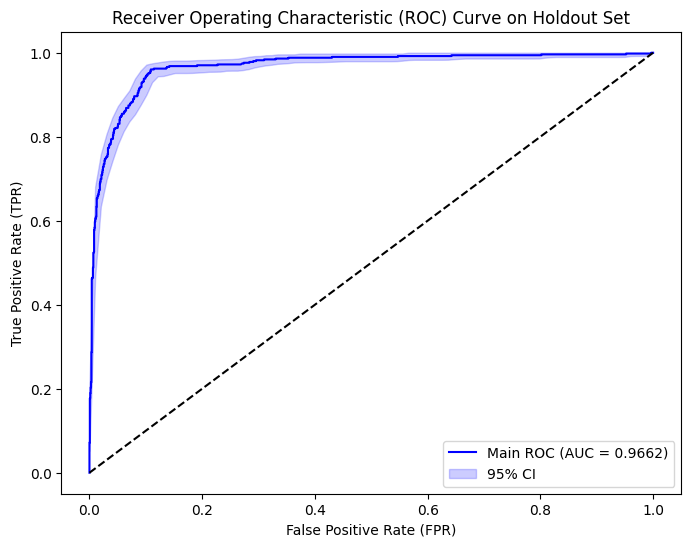

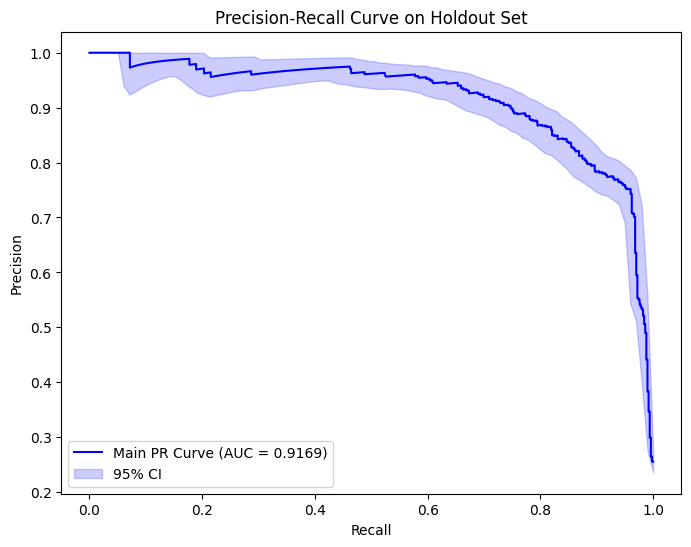

In [24]:
def calculate_confidence_intervals(curves, n_bins=100):
    mean_curve = np.linspace(0, 1, n_bins)
    interpolated_curves = [np.interp(mean_curve, curve[0], curve[1]) for curve in curves]
    lower_ci = np.percentile(interpolated_curves, 2.5, axis=0)
    upper_ci = np.percentile(interpolated_curves, 97.5, axis=0)
    mean_curve = np.mean(interpolated_curves, axis=0)
    return mean_curve, lower_ci, upper_ci

# Calculate confidence intervals for ROC
roc_fpr_interp = np.linspace(0, 1, 100)
roc_tpr_interp = [np.interp(roc_fpr_interp, fpr, tpr) for fpr, tpr in roc_curves_bootstrap]
roc_mean_tpr = np.mean(roc_tpr_interp, axis=0)
roc_lower_tpr = np.percentile(roc_tpr_interp, 2.5, axis=0)
roc_upper_tpr = np.percentile(roc_tpr_interp, 97.5, axis=0)

# Calculate confidence intervals for PR
pr_recall_interp = np.linspace(0, 1, 100)
pr_precision_interp = [np.interp(pr_recall_interp, recall[::-1], precision[::-1]) for precision, recall in pr_curves_bootstrap]
pr_mean_precision = np.mean(pr_precision_interp, axis=0)
pr_lower_precision = np.percentile(pr_precision_interp, 2.5, axis=0)
pr_upper_precision = np.percentile(pr_precision_interp, 97.5, axis=0)

# Plot ROC curve with confidence intervals
plt.figure(figsize=(8, 6))
plt.plot(roc_curves[0][0], roc_curves[0][1], label=f'Main ROC (AUC = {roc_curves[0][2]:.4f})', color='blue')
plt.fill_between(roc_fpr_interp, roc_lower_tpr, roc_upper_tpr, color='blue', alpha=0.2, label='95% CI')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve on Holdout Set')
plt.legend(loc='lower right')
plt.savefig('AUC_holdout.png')
plt.show()

# Plot PR curve with confidence intervals
plt.figure(figsize=(8, 6))
plt.plot(pr_curves[0][0], pr_curves[0][1], label=f'Main PR Curve (AUC = {pr_curves[0][2]:.4f})', color='blue')
plt.fill_between(pr_recall_interp, pr_lower_precision, pr_upper_precision, color='blue', alpha=0.2, label='95% CI')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve on Holdout Set')
plt.legend(loc='lower left')
plt.savefig('PR_holdout.png')
plt.show()

# Save all the data
df_holdout = pd.DataFrame({
    'metric': ['auc', 'f1', 'precision', 'recall', 'accuracy', 'auc_pr'],
    'value': [auc_cv, f1_cv, precision_sc, recall_sc, accuracy_sc, auc_pr],
    'ci_lower': [auc_ci[0], f1_ci[0], precision_ci[0], recall_ci[0], accuracy_ci[0], auc_pr_ci[0]],
    'ci_upper': [auc_ci[1], f1_ci[1], precision_ci[1], recall_ci[1], accuracy_ci[1], auc_pr_ci[1]]
})
df_holdout.to_csv('LR_holdout_metrics.csv', index=False)